# Random Forest
(by Tevfik Aytekin)

In [303]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import make_blobs


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### Why do ensemble methods work?

Suppose that we have a binary classification problem and built 3 models each of which can predict the class value of an example with 0.8 accuracy. Also assume that the models are independent of each other, i.e., the prediction one model makes is independent of the predictions of the other models. 

Now let us assume that we have a test example whose class value is 1. The following table shows all possible predictions of the 3 models.


|  M1 | M2  |  M3 |  Probability | Majority Prediction |
|---|---|---|---|---|
|  0 | 0  | 0  | 0.008  | 0|
|  0 | 0  | 1  | 0.032  | 0|
|  0 | 1  | 0  | 0.032  | 0|
|  0 | 1  | 1  | 0.128  | 1|
|  1 | 0  | 0  | 0.032  | 0|
|  1 | 0  | 1  | 0.128  | 1|
|  1 | 1  | 0  | 0.128  | 1|
|  1 | 1  | 1  | 0.512  | 1|

The probability that the example will be classified as 1 is:

$$0.128+0.128+0.128+0.512 = 0.896$$

which is higher than 0.8. Hence the ensemble of 3 models has a higher accuracy than a single model. This increase in accuracy is only possible if the base classifiers are independent which is difficult to have in practice. However, even if base classifiers are slightly correlated it is possible to see improvements in the ensemble classifiers.


In general the classification accuracy of an ensemble of $n$ base classifiers where the classification accuracy of the base classifiers is $a$ is given by the following formula:

$$
\sum_{i=\lfloor{n/2} \rfloor+1}^n {n \choose i} a^i(1-a)^{n-i}
$$

Below is a plot which shows the accuracy of the ensemble classifiers versus the accuracy of the base classifiers.


In [304]:
def nCr(n,i):
    f = math.factorial
    return f(n) / f(i) / f(n-i)

def ensemble_acc(n, a):
    sum = 0
    m = int(np.floor(n/2)+1)
    for i in range(m,n+1):
        sum += nCr(n, i)*pow(a,i)*pow(1-a,n-i)
    return sum
    


Text(0, 0.5, 'Ensemble Classifier Classification Accuracy')

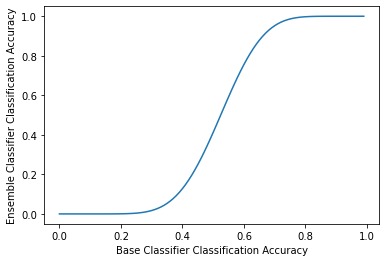

In [4]:
x = np.arange(0,1,0.01)
n_base_classifiers = 20
plt.plot(x, [ensemble_acc(n_base_classifiers,i) for i in x])
plt.xlabel('Base Classifier Classification Accuracy')
plt.ylabel('Ensemble Classifier Classification Accuracy')

In [306]:
a = np.array([110,180,160,96,225,300,140,250,80,150])
np.mean(a)

169.1

### Wisdom of the Crowd

In [320]:
np.random.randint(1,10,5)

array([8, 2, 4, 8, 4])

<AxesSubplot:>

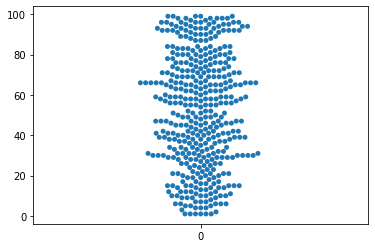

In [328]:
a = np.random.randint(1,100, 415)
sns.swarmplot(data = a)


### Random Forest Classifier

In [285]:
class MyRandomForestClassifier:
    
    def __init__(self, n_estimators = 100, max_features = 'sqrt', max_depth = None, bootstrap=True):
        self.models = []
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.bootstrap = bootstrap
    
    def predict(self,X):
        preds = pd.DataFrame()
        
        for i, t in enumerate(self.models):
            preds[i] = t.predict(X)
        return preds.mode(axis=1)[0].astype(int)
    
    def fit(self, X, y):
        n_features = np.shape(X)[1]
        n_examples = np.shape(X)[0]
           
        for i in range(self.n_estimators):
            # sample with replacement (bootstrapping)
            if self.bootstrap:
                X1, y1 = resample(X, y, n_samples = n_examples, replace=True)
            else:
                X1, y1 = X, y
                       
            tree = DecisionTreeClassifier(max_features=self.max_features)
            tree.fit(X1, y1)
            
            # Append the tree 
            self.models.append(tree)


In [286]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
# print first 5 examples
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [287]:
bank.shape

(45211, 17)

In [288]:
bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [289]:
bank_majority = bank[bank.y=="no"]
bank_minority = bank[bank.y=="yes"]
 
# downsample
bank_majority_downsampled = resample(bank_majority, 
                                 replace=False,    
                                 n_samples=5289) 
 
bank_balanced = pd.concat([bank_minority, bank_majority_downsampled])
bank_balanced.y.value_counts()

yes    5289
no     5289
Name: y, dtype: int64

### Random Forest Experiment

Random sampling of features and bootstrapping are the two major sources of variation. In order to see the effects of both try setting bootstrap = False or max_features = np.shape(X)[1]

In [290]:
X = bank_balanced.loc[:,'age':'poutcome']
y = bank_balanced.loc[:,'y']

y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier(n_estimators=100, bootstrap=False, max_features = "sqrt")
clf3 = MyRandomForestClassifier(n_estimators=100, bootstrap=False, max_features = "sqrt")

clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);
clf3.fit(X_train, y_train);

y_pred1 = clf1.predict(X_test)  
y_pred2 = clf2.predict(X_test) 
y_pred3 = clf3.predict(X_test) 
print(classification_report(y_test,y_pred1))
print(classification_report(y_test,y_pred2))
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       523
           1       0.82      0.81      0.82       535

    accuracy                           0.81      1058
   macro avg       0.81      0.81      0.81      1058
weighted avg       0.81      0.81      0.81      1058

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       523
           1       0.85      0.93      0.89       535

    accuracy                           0.88      1058
   macro avg       0.89      0.88      0.88      1058
weighted avg       0.89      0.88      0.88      1058

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       523
           1       0.86      0.93      0.90       535

    accuracy                           0.89      1058
   macro avg       0.89      0.89      0.89      1058
weighted avg       0.89      0.89      0.89      1058



### Random Forest Regressor

In [291]:
class MyRandomForestRegressor:
    
    def __init__(self, n_estimators = 100, max_features = 'sqrt', max_depth = None, bootstrap=True):
        self.models = []
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.bootstrap = bootstrap
    
    def predict(self,X):
        preds = 0
        for i, t in enumerate(self.models):
            preds += t.predict(X)
        return preds / len(self.models)
    
    def fit(self, X, y):

        n_features = np.shape(X)[1]
        n_examples = np.shape(X)[0]
        

        for i in range(self.n_estimators):
            # sample with replacement (bootstrapping)
            if self.bootstrap:
                X1, y1 = resample(X, y, n_samples = n_examples, replace=True)
            else:
                X1, y1 = X, y
                       
            tree = DecisionTreeRegressor(max_features=self.max_features)
            tree.fit(X1, y1)
            
            # Append the tree 
            self.models.append(tree)


In [292]:
house_train = pd.read_csv("../datasets/house_prices/train.csv")

In [302]:
from sklearn.metrics import mean_absolute_error
X = house_train.loc[:,'MSSubClass':'SaleCondition']
y = house_train.loc[:,'SalePrice']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

reg1 = DecisionTreeRegressor()
reg2 = RandomForestRegressor(n_estimators=100, bootstrap=False, max_features = "sqrt")
reg3 = MyRandomForestRegressor(n_estimators=100,bootstrap=False, max_features = "sqrt")

reg1.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)

print(mean_absolute_percentage_error(y_test, reg1.predict(X_test)))
print(mean_absolute_percentage_error(y_test, reg2.predict(X_test)))
print(mean_absolute_percentage_error(y_test, reg3.predict(X_test)))

14.455744431872683
9.404022747970368
9.018083281733007


In [ ]:
print(mean_absolute_error(y_test, reg1.predict(X_test)))
print(mean_absolute_error(y_test, reg2.predict(X_test)))
print(mean_absolute_error(y_test, reg3.predict(X_test)))

In [177]:
from sklearn.metrics import mean_squared_log_error

def kaggle_score(y_true,y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred));

In [178]:
print(kaggle_score(y_test, reg1.predict(X_test)))
print(kaggle_score(y_test, reg2.predict(X_test)))
print(kaggle_score(y_test, reg3.predict(X_test)))

0.20087908076383046
0.14010206039190962
0.15058899830226322
